# import dependencies

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas.plotting import scatter_matrix

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
df = read_csv('processed_data.csv')
df.head()

,Unnamed: 0,date,time,account,interface,sourceIP,destIP,srcPort,dstPort,protocol,packets,byte,startTime,timeTook,status,Cattemptlastsec,Rlastsec
0,1,2021-02-10,2021-07-03 18:15:00,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,9622,6,5,689,1612980900,9,1,1.0,NaN
1,3,2021-02-10,2021-07-03 18:15:00,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,22050,6,5,582,1612980900,9,1,2.0,NaN
2,5,2021-02-10,2021-07-03 18:15:00,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,51466,6,11,10996,1612980900,9,1,3.0,NaN
3,7,2021-02-10,2021-07-03 18:15:00,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,49748,6,13,12958,1612980900,9,1,4.0,NaN
4,9,2021-02-10,2021-07-03 18:15:00,430405884063,eni-0b6ce86ea40aaa41b,172.16.1.52,50.245.225.205,80,18681,6,5,638,1612980900,9,1,5.0,NaN


Remove unneeded Collumns and reformat numbers to integers

In [3]:
# Remove Unneeded Columns
df.pop("interface")
df.pop("account")
df.pop("Unnamed: 0")
df.pop('date')
df.pop('Rlastsec')
df.pop('time')
df.pop('protocol')
df.pop('srcPort')
df.pop('dstPort')
df.pop('Cattemptlastsec')



#only IPs based on sec, number of same reponse(same source and dest ip), accept rate, startTime, average timeTook

df.pop('byte')
df.pop('packets')

# Reformat numbers
df['sourceIP'] = df['sourceIP'].str.replace(r'\D', '')
df['destIP'] = df['destIP'].str.replace(r'\D', '')
df['sourceIP'] = pd.to_numeric(df['sourceIP'])
df['destIP'] = pd.to_numeric(df['destIP'])
df['startTime'] = pd.to_numeric(df['startTime'])
df['timeTook'] = pd.to_numeric(df['timeTook'])
df['status'] = pd.to_numeric(df['status'])

df.head()

<ipython-input-3-9e48dbf01f4b>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sourceIP'] = df['sourceIP'].str.replace(r'\D', '')
<ipython-input-3-9e48dbf01f4b>:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df['destIP'] = df['destIP'].str.replace(r'\D', '')


,sourceIP,destIP,startTime,timeTook,status
0,17216152,50245225205,1612980900,9,1
1,17216152,50245225205,1612980900,9,1
2,17216152,50245225205,1612980900,9,1
3,17216152,50245225205,1612980900,9,1
4,17216152,50245225205,1612980900,9,1


In [5]:
df = df.sort_values(['startTime','sourceIP', 'destIP',],ascending=[True, True, True])
df = df.reset_index(drop=True)
df.head()

,sourceIP,destIP,startTime,timeTook,status
0,17216152,172161196,1612980720,8,1
1,17216152,172161196,1612980720,8,1
2,17216152,172161196,1612980720,8,1
3,17216152,172161196,1612980720,8,1
4,17216152,172161196,1612980720,8,1


In [6]:
#preprocess the data
#O(n)
processedDf = pd.DataFrame({
    "sourceIP":[],
    "destIP":[],
    "numOfRequest":[],
    "time":[],
    "acceptanceRate":[],
    "averageTimeTook":[],
})
for index, line in df.iterrows():
    if index == 0:
        m = 100
        if line['status'] == 0:
            m = 0
        processedDf.loc[0] = [line['sourceIP'],line['destIP'],1,line['startTime'],m,line['timeTook']]
    else:
        n = len(processedDf)-1
        if processedDf.loc[n,'sourceIP']==line['sourceIP'] and processedDf.loc[n,'destIP']==line['destIP'] and processedDf.loc[n,'time']==line['startTime']:
            x = processedDf.loc[n,'numOfRequest']
            processedDf.loc[n,'numOfRequest'] = x + 1
            if line['status'] == 1:
                processedDf.loc[n,'acceptanceRate'] = (((x*processedDf.loc[n,'acceptanceRate']*0.01)+1)/(x+1)) * 100
            else:
                processedDf.loc[n,'acceptanceRate'] = (((x*processedDf.loc[n,'acceptanceRate']*0.01))/(x+1)) * 100
            processedDf.loc[n,'averageTimeTook'] = ((processedDf.loc[n,'averageTimeTook'] * x)+line['timeTook'])/(x+1)
        else:
            m = 100
            if line['status'] == 0:
                m = 0
            processedDf.loc[n+1] = [line['sourceIP'],line['destIP'],1,line['startTime'],m,line['timeTook']]
processedDf.head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate,averageTimeTook
0,17216152.0,172161196.0,5.0,1.612981e+09,100.0,8.0
1,17216152.0,502303538.0,4.0,1.612981e+09,100.0,8.0
2,172161196.0,17216152.0,5.0,1.612981e+09,100.0,8.0
3,502303538.0,17216152.0,4.0,1.612981e+09,100.0,8.0
4,10325299.0,172161196.0,5.0,1.612981e+09,100.0,13.0


In [21]:
processedDf.to_csv('processed_data2.csv')

View data to determine correlations, groupings, outliers, and any other trends (only 5% of the data graphed)

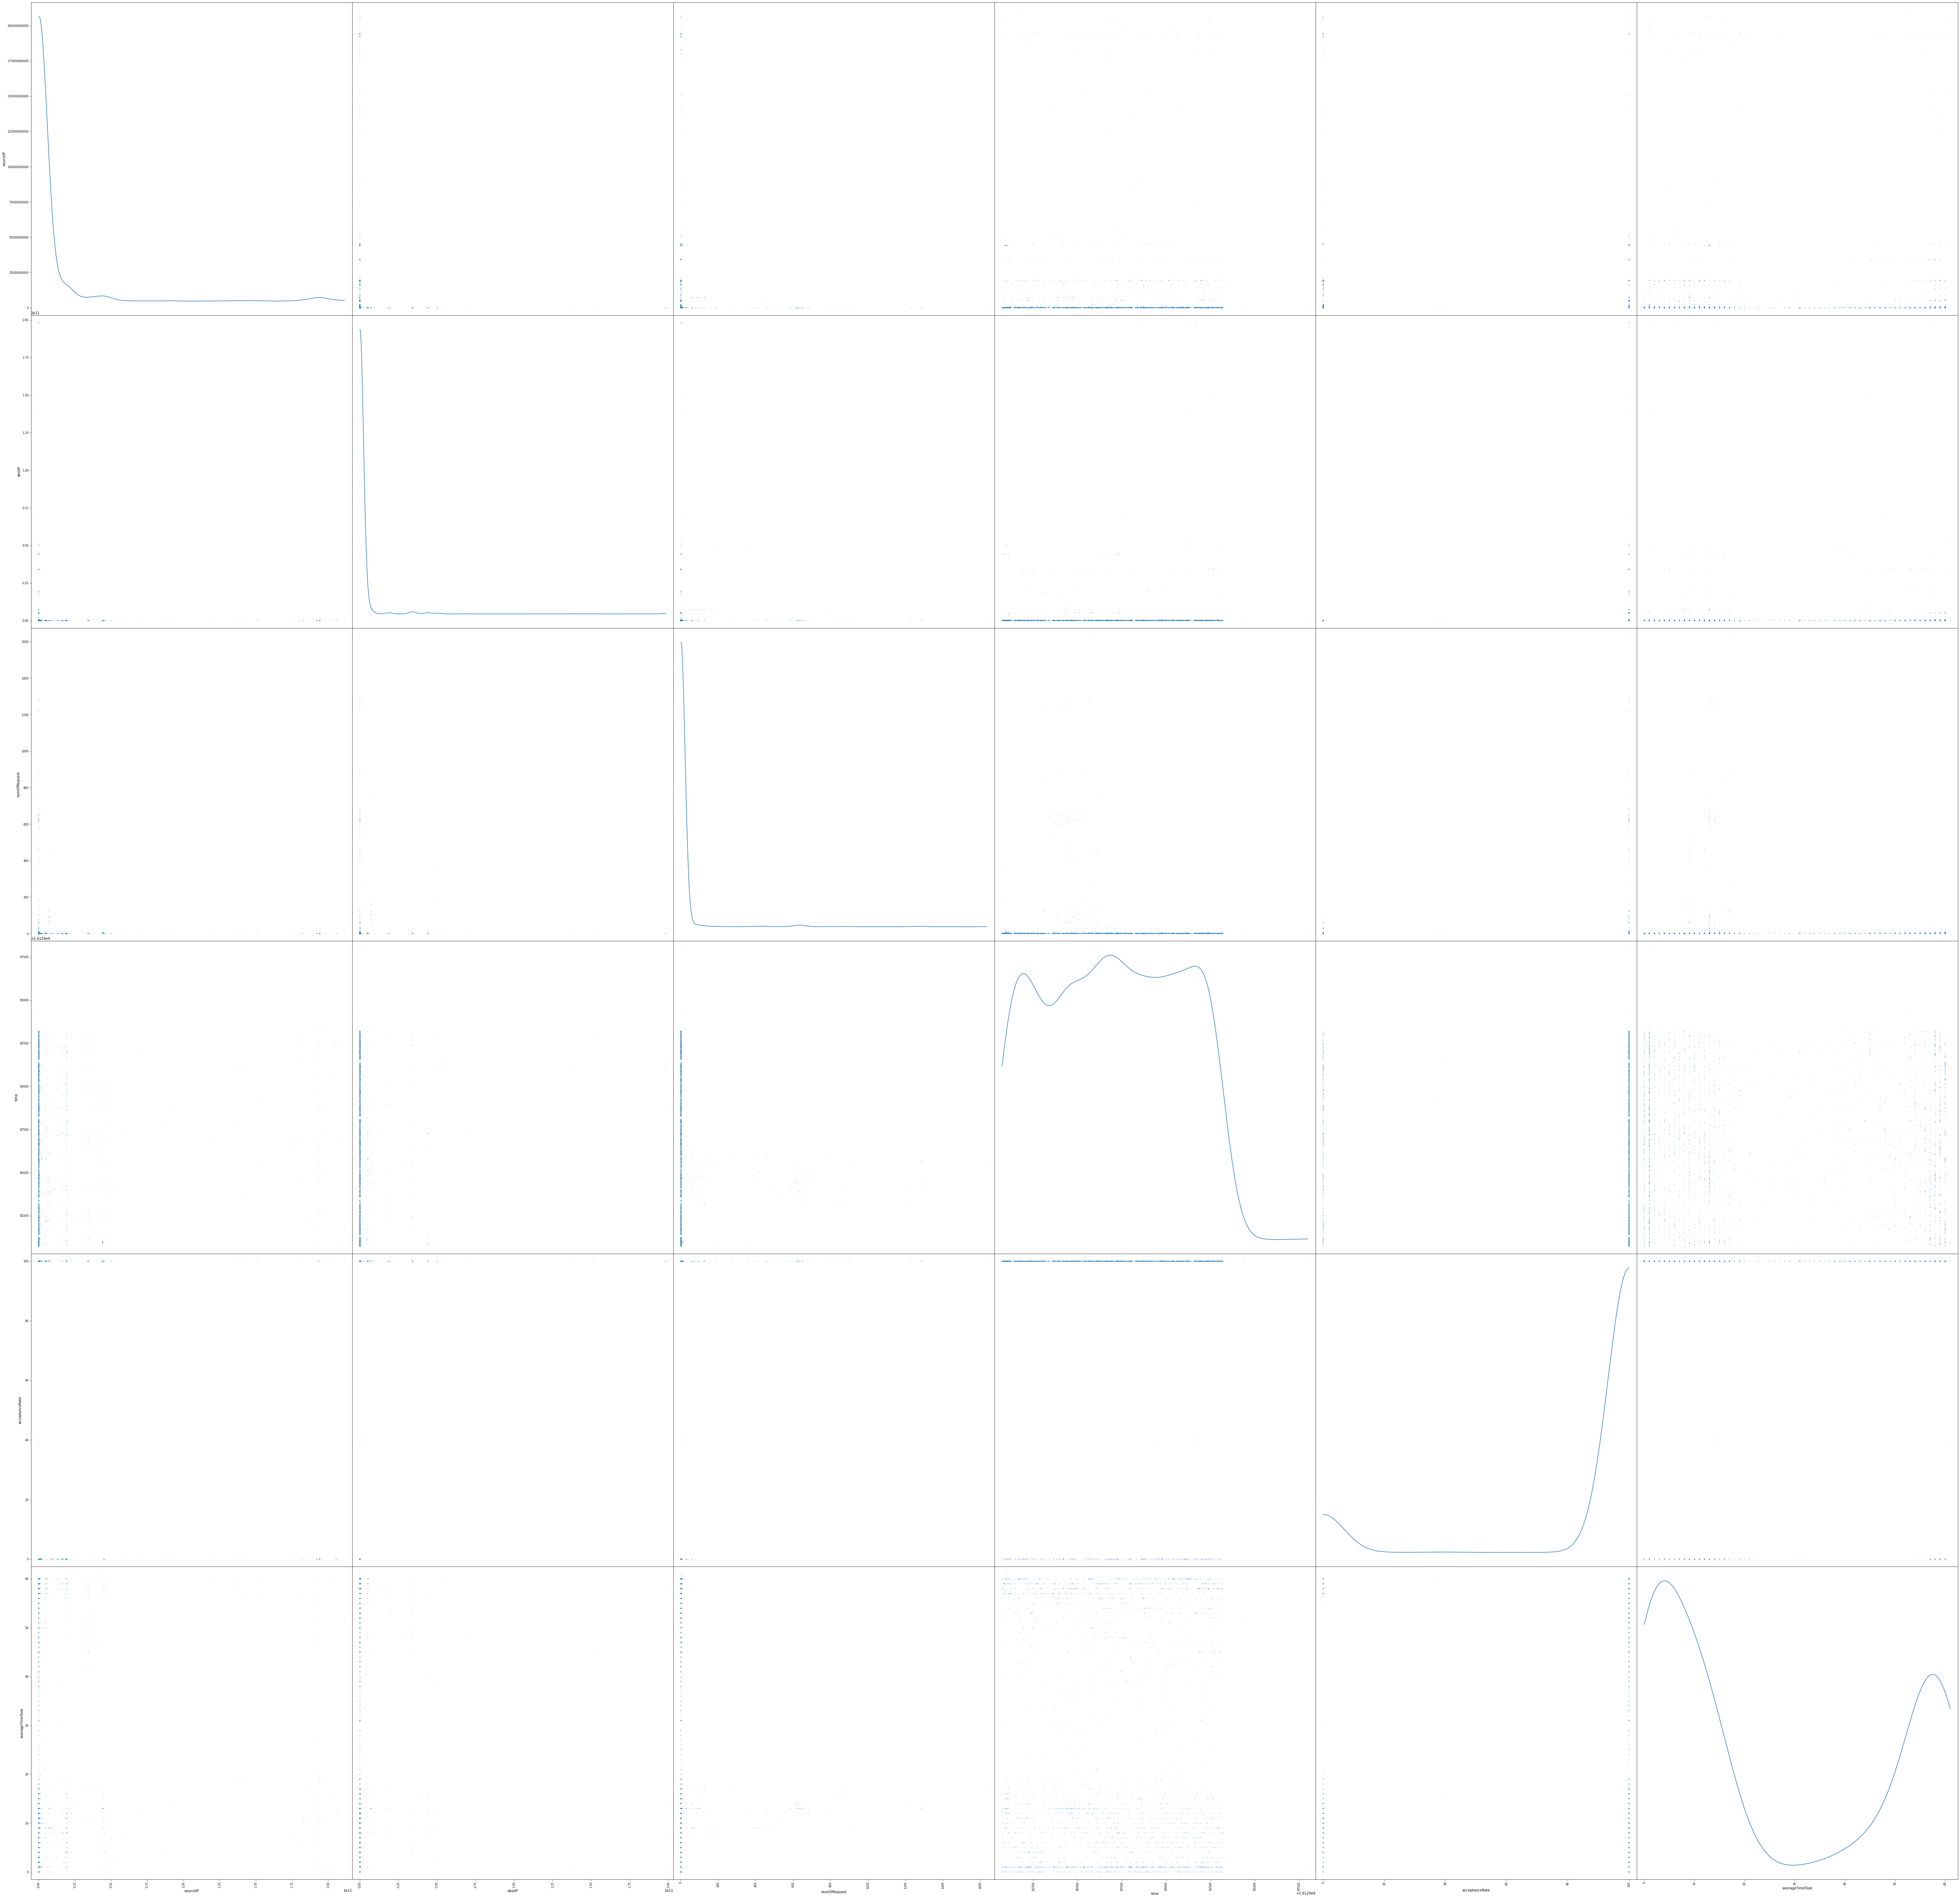

In [22]:
fig = scatter_matrix(processedDf.sample(frac=0.05), alpha=0.2,figsize=(100,100), diagonal="kde")  

In [9]:
df = processedDf    

In [22]:
from numpy import nan
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

#df['is_attack'] = nan
# We choose 3 times above standard deviation for the extreme outliner
#df['is_attack'] = (df['numOfRequest'] > df['numOfRequest'].mean()+df['numOfRequest'].std()*3) | (df['acceptanceRate'] > df['acceptanceRate'].mean()+df['acceptanceRate'].std()*3) 
# This is our rule for our data

# This is our dataset to train, tweak, and test our model on.
X = df.loc[:, ['numOfRequest', 'acceptanceRate']]

kmeans = KMeans(n_clusters = 2) # is attack or not attack into 2 clusters
kmeans.fit(X)
df['is_attack'] = kmeans.labels_

y = df['is_attack'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, verbose=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14379
           1       1.00      1.00      1.00       295

    accuracy                           1.00     14674
   macro avg       1.00      1.00      1.00     14674
weighted avg       1.00      1.00      1.00     14674



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [23]:
df['probabilityOfAttack'] = clf.predict_proba(X)[:,1]

In [27]:
df.sort_values(by='probabilityOfAttack',ascending=False).head()

,sourceIP,destIP,numOfRequest,time,acceptanceRate,averageTimeTook,is_attack,probabilityOfAttack
13320,1.721612e+08,17216152.0,614.0,1.612985e+09,100.0,14.000000,1,1.0
9897,1.721615e+07,172161196.0,784.0,1.612984e+09,100.0,17.000000,1,1.0
11953,1.721612e+08,17216152.0,509.0,1.612984e+09,100.0,7.045187,1,1.0
19314,7.318014e+09,17216152.0,596.0,1.612986e+09,100.0,13.000000,1,1.0
16059,1.721612e+08,17216152.0,634.0,1.612985e+09,100.0,13.000000,1,1.0


In [28]:
df.to_csv('result.csv')